In [1]:
from autometrics.dataset.datasets.simplification import SimpDA
from autometrics.util.analysis import display_top_5_metrics_by_validation, get_top_metric_by_validation, plot_metric_target_scatterplot
from autometrics.evaluate.correlation import calculate_correlation
from autometrics.aggregator.regression import Ridge
from autometrics.generator.LLMJudgeProposer import LLMJudgeProposer
from autometrics.metrics.MetricBank import all_metrics
import dspy
import pandas as pd
pd.set_option('display.max_colwidth', None)

import litellm

litellm.suppress_debug_info = True

/opt/miniconda3/envs/auto_eval/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = SimpDA()

In [3]:
dataset.add_metrics(all_metrics)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 41/41 [01:01<00:00,  1.49s/it]


computing greedy matching.


100%|██████████| 68/68 [00:00<00:00, 196.99it/s]

done in 61.64 seconds, 70.41 sentences/sec


In [4]:
train, dev, test = dataset.get_splits(train_ratio=0.2, val_ratio=0.3, seed=42)

In [5]:
llama31_70b = dspy.LM("openai/meta-llama/Meta-Llama-3-70b-Instruct", api_base="http://future-hgx-1:7410/v1", api_key="None")

dspy.settings.configure(lm=llama31_70b)

In [6]:
llama31_70b.model

'openai/meta-llama/Meta-Llama-3-70b-Instruct'

In [7]:
from autometrics.metrics.llm_judge.LLMJudgeOptimized import LLMJudgeOptimized

In [8]:
# fluency_optimized = LLMJudgeOptimized(
#     name="fluency_" + llama31_70b.model.split('/')[-1], 
#     description="fluency", 
#     model=llama31_70b,
#     train_dataset=train,
#     task_description="Given a complicated original sentence, simplify it in a way such that a broader audience could easily understand it.",
#     target_column="fluency",
#     output_prompt_path='simpda_fluency_prompt.dspy',
#     metric_name="fluency",
# )

In [ ]:
for target_column in dataset.target_columns:
    new_metric = LLMJudgeOptimized(
        name=target_column + "_" + llama31_70b.model.split('/')[-1], 
        description="Optimized LLM as a judge for " + target_column, 
        model=llama31_70b,
        train_dataset=train,
        task_description="Given a complicated original sentence, simplify it in a way such that a broader audience could easily understand it.",
        target_column=target_column,
        output_prompt_path='simpda_' + target_column + '_prompt.dspy',
        metric_name=target_column,
    )

    train.add_metrics([new_metric])
    dev.add_metrics([new_metric])
    test.add_metrics([new_metric])

Prepared 82 examples for training.
Example({'text': '«Input (original): «advocacy countries with a minority muslim population are more likely than muslim-majority countries of the greater middle east to use mosques as a way to promote civic participation.»\nReference 1 (ref1): «mosques play a larger role in civic participation in advocacy countries with a muslim minority.»\nReference 2 (ref2): «countries with a minority muslim population are more likely to use mosques to promote civil participation than muslim-majority countries in the middle east.»\nReference 3 (ref3): «advocacy countries with minority muslim populations are more likely than muslim majority countries from the greater middle east to have mosques to get people to be a part of the community.»\nReference 4 (ref4): «advocacy countries with a minority of muslims are more likely than countries with a majority of muslims to use mosques to promote civic participation.»\nReference 5 (ref5): «countries with a smaller muslim popu

 47%|████▋     | 8/17 [00:27<00:30,  3.43s/it]


Bootstrapped 8 full traces after 9 examples in round 0.
Bootstrapping set 4/19


 18%|█▊        | 3/17 [00:09<00:42,  3.06s/it]


Bootstrapped 3 full traces after 4 examples in round 0.
Bootstrapping set 5/19


 35%|███▌      | 6/17 [00:19<00:35,  3.25s/it]


Bootstrapped 6 full traces after 7 examples in round 0.
Bootstrapping set 6/19


  6%|▌         | 1/17 [00:02<00:42,  2.63s/it]


Bootstrapped 1 full traces after 2 examples in round 0.
Bootstrapping set 7/19


 47%|████▋     | 8/17 [00:31<00:34,  3.88s/it]


Bootstrapped 8 full traces after 9 examples in round 0.
Bootstrapping set 8/19


 18%|█▊        | 3/17 [00:13<01:03,  4.55s/it]


Bootstrapped 3 full traces after 4 examples in round 0.
Bootstrapping set 9/19


  6%|▌         | 1/17 [00:03<01:01,  3.85s/it]


Bootstrapped 1 full traces after 2 examples in round 0.
Bootstrapping set 10/19


 41%|████      | 7/17 [00:24<00:35,  3.50s/it]


Bootstrapped 7 full traces after 8 examples in round 0.
Bootstrapping set 11/19


  6%|▌         | 1/17 [00:06<01:49,  6.86s/it]


Bootstrapped 1 full traces after 2 examples in round 0.
Bootstrapping set 12/19


  6%|▌         | 1/17 [00:03<01:02,  3.89s/it]


Bootstrapped 1 full traces after 2 examples in round 0.
Bootstrapping set 13/19


  0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
display_top_5_metrics_by_validation(dev, test, True)

,Top 1 Metric & Value,Top 2 Metric & Value,Top 3 Metric & Value,Top 4 Metric & Value,Top 5 Metric & Value
fluency,BERTScoreP_roberta-large (0.5799887010646303),meaning_llama70b (0.5553883577737645),BERTScoreF_roberta-large (0.5376877382185893),fluency_llama70b (0.48238931158293596),simplicity_llama70b (0.41671800383040175)
meaning,BERTScoreF_roberta-large (0.7232674330257098),BERTScoreP_roberta-large (0.6106572417507335),BERTScoreR_roberta-large (0.7413929364907887),meaning_llama70b (0.6892009091858224),CHRF (0.6554432845335177)
simplicity,BERTScoreP_roberta-large (0.6150344373913592),meaning_llama70b (0.598473412138742),fluency_llama70b (0.4903860139690011),simplicity_llama70b (0.511476724955242),BERTScoreF_roberta-large (0.5279062401502087)


In [ ]:
from tqdm import tqdm
for target in tqdm(dataset.get_target_columns()):
    aggregator = Ridge(dataset=train, name=f'Ridge_{target}_llm')
    aggregator.ensure_dependencies(train)
    aggregator.ensure_dependencies(dev)
    aggregator.ensure_dependencies(test)

100%|██████████| 3/3 [00:00<00:00, 12.39it/s]


In [ ]:
train.get_metric_columns()

['BLEU',
 'CHRF',
 'TER',
 'GLEU',
 'SARI_P',
 'SARI_F',
 'BERTScoreP_roberta-large',
 'BERTScoreR_roberta-large',
 'BERTScoreF_roberta-large',
 'FKGL',
 'Preservation of original meaning_Meta-Llama-3-70b-Instruct',
 'Simplification of vocabulary_Meta-Llama-3-70b-Instruct',
 'Simplification of sentence structure_Meta-Llama-3-70b-Instruct',
 'Grammatical correctness_Meta-Llama-3-70b-Instruct',
 'Relevance to the original sentence_Meta-Llama-3-70b-Instruct',
 'Clarity and concision_Meta-Llama-3-70b-Instruct',
 'Relevance to context_Meta-Llama-3-70b-Instruct',
 'Avoidance of misinterpretation_Meta-Llama-3-70b-Instruct',
 'Retention of original meaning_Meta-Llama-3-70b-Instruct',
 'Use of simple vocabulary_Meta-Llama-3-70b-Instruct',
 'Sentence structure_Meta-Llama-3-70b-Instruct']

In [ ]:
for target in tqdm(dataset.get_target_columns()):
    aggregator = Ridge(dataset=train, name=f'Ridge_{target}_llm')
    aggregator.learn(train, target)
    aggregator.predict(train)
    aggregator.predict(dev)
    aggregator.predict(test)

100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


In [ ]:
display_top_5_metrics_by_validation(dev, test, True)

,Top 1 Metric & Value,Top 2 Metric & Value,Top 3 Metric & Value,Top 4 Metric & Value,Top 5 Metric & Value
fluency,Grammatical correctness_llama70b (0.6672669809...,Rg_simplicity_llm (0.6620135998278146),Rg_fluency_llm (0.6587305152510782),Rg_meaning_llm (0.6168635730651805),Clarity and concision_llama70b (0.533269781989...
meaning,Rg_meaning_llm (0.8518249214445299),Preservation of original meaning_llama70b (0.8...,Relevance to the original sentence_llama70b (0...,Clarity and concision_llama70b (0.785786322205...,Avoidance of misinterpretation_llama70b (0.821...
simplicity,Grammatical correctness_llama70b (0.7328514696...,Rg_simplicity_llm (0.7646480620133647),Rg_meaning_llm (0.6668407696368384),Rg_fluency_llm (0.7137465461754362),Clarity and concision_llama70b (0.661479179608...


In [ ]:
display_top_5_metrics_by_validation(test, test, True)

,Top 1 Metric & Value,Top 2 Metric & Value,Top 3 Metric & Value,Top 4 Metric & Value,Top 5 Metric & Value
fluency,Grammatical correctness_llama70b (0.6672669809...,Rg_simplicity_llm (0.6620135998278146),Rg_fluency_llm (0.6587305152510782),Rg_meaning_llm (0.6168635730651805),BERTScoreP_roberta-large (0.5799887010646303)
meaning,Rg_meaning_llm (0.8518249214445299),Preservation of original meaning_llama70b (0.8...,Avoidance of misinterpretation_llama70b (0.821...,Relevance to the original sentence_llama70b (0...,Clarity and concision_llama70b (0.785786322205...
simplicity,Rg_simplicity_llm (0.7646480620133647),Grammatical correctness_llama70b (0.7328514696...,Rg_fluency_llm (0.7137465461754362),Rg_meaning_llm (0.6668407696368384),Clarity and concision_llama70b (0.661479179608...


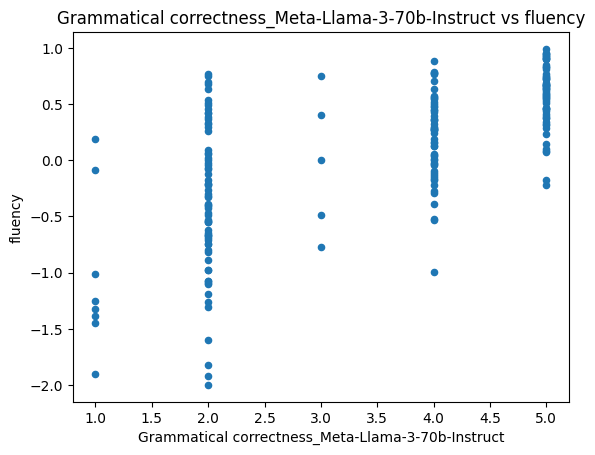

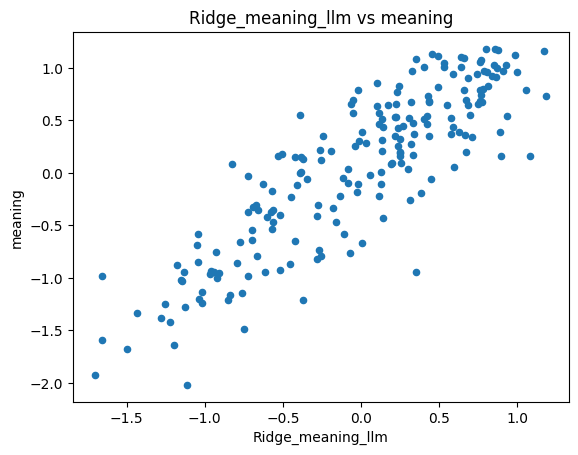

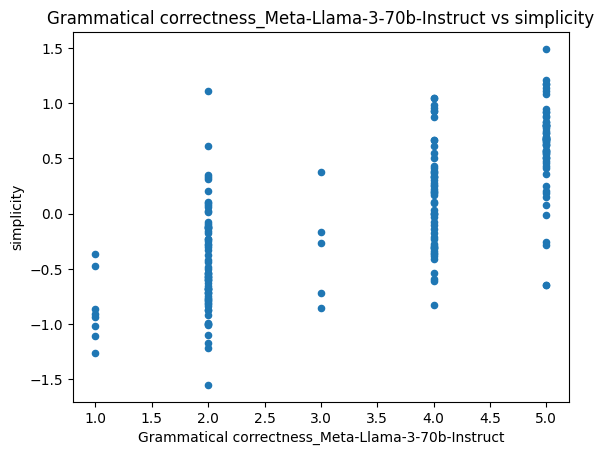

In [ ]:
for target_column in dataset.target_columns:
    metric = get_top_metric_by_validation(dev, target_column, True)
    plot_metric_target_scatterplot(test, metric, target_column)
